In [1]:
### Import necessary libraries

from typing import Dict, Text

import numpy as np
import tensorflow as tf

import tensorflow_recommenders as tfrs

import os
import pprint
import tempfile

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
masterdf = pd.read_csv('../data_cleaned/brazildata_mod.csv')
masterdf.head(3)

,Unnamed: 0,order_id,order_purchase_timestamp,user_id,customer_city,customer_state,product_category,quantity,price,review_score,timestamp,product_code,product_id
0,0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,9ef432eb6251297304e76186b10a928d,sao paulo,SP,housewares,1.0,29.99,4,1.506942e+09,87285b34884572647811a353c7ac498a,housewares SKU 0
1,1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,b0830fb4747a6c6d20dea0b8c802d7ef,barreiras,BA,perfumery,1.0,118.70,4,1.532465e+09,595fac2a385ac33a80bd5114aec74eb8,perfumery SKU 0
2,2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,41ce2a54c0b03bf3443c3d931a367089,vianopolis,GO,auto,1.0,159.90,5,1.533718e+09,aa4383b373c6aca5d8797843e5594415,auto SKU 0


In [3]:
### standardize item data types, especially string, float, and integer

masterdf[['user_id',      
          'product_id',  
         ]] = masterdf[['user_id','product_id']].astype(str)

# we will play around with the data type of the quantity, 
# which you shall see later it affects the accuracy of the prediction.

masterdf['quantity'] = masterdf['quantity'].astype(float)

In [4]:
### define interactions data and user data

### interactions 
### here we create a reference table of the user , item, and quantity purchased
interactions_dict = masterdf.groupby(['user_id', 
                                      'customer_city',
                                      'product_category',
                                      'product_id', 
                                      'timestamp'])[ 'quantity'].sum().reset_index()

interactions_dict = {name: np.array(value) for name, value in interactions_dict.items()}
interactions = tf.data.Dataset.from_tensor_slices(interactions_dict)

## item features
items_dict = masterdf[['product_id']].drop_duplicates()
items_dict = {name: np.array(value) for name, value in items_dict.items()}
items = tf.data.Dataset.from_tensor_slices(items_dict)

## map the features in interactions and items

# Select the basic features.
interactions = interactions.map(lambda x: {
    'user_id' : str(x['user_id']), 
    'customer_city' : str(x['customer_city']),
    'product_id' : str(x['product_id']), 
    'product_category' : str(x['product_category']),   
    'quantity' : int(x['quantity']),
    "timestamp": int(x["timestamp"])
})

items = items.map(lambda x: str(x['product_id']))
city = interactions.map(lambda x: str(x['customer_city']))
category = interactions.map(lambda x: str(x['product_category']))


In [5]:
unique_item_titles = np.unique(np.concatenate(list(items.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["user_id"]))))
unique_city = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["customer_city"]))))
unique_product_category = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["product_category"]))))

In [6]:
## Normalizing continuous features
## Continuous features also need normalization. For example, the timestamp feature is far too large to be used directly in a deep model:

timestamps = np.concatenate(list(interactions.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

## there are other methods to reduce the size of the timestamp, such as standardization
## here we use discretization
timestamp_buckets = np.linspace(min_timestamp, max_timestamp, num=1000,)

In [13]:
# Randomly shuffle data and split between train and test.
tf.random.set_seed(42)
shuffled = interactions.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(60_000)
test = shuffled.skip(60_000).take(20_000)

Add more features to take advantage of cross network, then use retrieval task

In [7]:
class UserModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        
        self.embedding_dimension = 32
        max_tokens = 10_000

        ## user id
        self.user_embedding = tf.keras.Sequential([
                                                    tf.keras.layers.experimental.preprocessing.StringLookup(
                                                    vocabulary=unique_user_ids, mask_token=None),
                                                    tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
                                                    ])
        #timestamp
        self.timestamp_embedding = tf.keras.Sequential([
                                    tf.keras.layers.experimental.preprocessing.Discretization(timestamp_buckets.tolist()),
                                    tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
                                ])
        self.normalized_timestamp = tf.keras.layers.experimental.preprocessing.Normalization()

        self.normalized_timestamp.adapt(timestamps)
        
        # city features
        self.city_embedding = tf.keras.Sequential([
                                          tf.keras.layers.experimental.preprocessing.StringLookup(
                                            vocabulary=unique_city, mask_token=None),
                                          tf.keras.layers.Embedding(len(unique_city) + 1, self.embedding_dimension)
                                        ])
        self.city_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
                                                                                        max_tokens=max_tokens)
        self.city_text_embedding = tf.keras.Sequential([
                                  self.city_vectorizer,
                                  tf.keras.layers.Embedding(max_tokens, self.embedding_dimension, mask_zero=True),
                                  tf.keras.layers.GlobalAveragePooling1D(),
                                ])

        self.city_vectorizer.adapt(city)    
              
        # product category  
        self.category_embedding = tf.keras.Sequential([
                                  tf.keras.layers.experimental.preprocessing.StringLookup(
                                    vocabulary=unique_product_category, mask_token=None),
                                  tf.keras.layers.Embedding(len(unique_product_category) + 1, self.embedding_dimension)
                                ])
        
        self.category_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
                                                                                        max_tokens=max_tokens)
        self.category_text_embedding = tf.keras.Sequential([
                                  self.category_vectorizer,
                                  tf.keras.layers.Embedding(max_tokens, self.embedding_dimension, mask_zero=True),
                                  tf.keras.layers.GlobalAveragePooling1D(),
                                ])

        self.category_vectorizer.adapt(category)
        

    def call(self, inputs):
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result.
        return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.timestamp_embedding(inputs["timestamp"]),
            self.normalized_timestamp(inputs["timestamp"]),
            self.city_embedding(inputs["customer_city"]),
            self.city_text_embedding(inputs["customer_city"]),
            self.category_embedding(inputs["product_category"]),
            self.category_text_embedding(inputs["product_category"]),
#             self.category_embedding(['product_category'])
        ], axis=1)

In [8]:
class QueryModel(tf.keras.Model):
    """Model for encoding user queries."""

    def __init__(self, layer_sizes, projection_dim=None):
        """Model for encoding user queries.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        # We first use the user model for generating embeddings.
        self.embedding_model = UserModel()
            
#         self.dense_layers = tf.keras.Sequential([
#                                     tfrs.layers.dcn.Cross(projection_dim=projection_dim,
#                                                           kernel_initializer="glorot_uniform"),
#                                     tf.keras.layers.Dense(256, activation="relu"),
#                                     tf.keras.layers.Dense(128, activation="relu"),
#                                     tf.keras.layers.Dense(1)
#             ])

        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential(tfrs.layers.dcn.Cross(projection_dim=projection_dim,
                                        kernel_initializer="glorot_uniform"))

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [9]:
class ItemModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        
        self.embedding_dimension = 32

        max_tokens = 10_000

        self.title_embedding = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
              vocabulary=unique_item_titles,mask_token=None),
          tf.keras.layers.Embedding(len(unique_item_titles) + 1, self.embedding_dimension)
        ])

        self.title_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
            max_tokens=max_tokens)

        self.title_text_embedding = tf.keras.Sequential([
          self.title_vectorizer,
          tf.keras.layers.Embedding(max_tokens, self.embedding_dimension, mask_zero=True),
          tf.keras.layers.GlobalAveragePooling1D(),
        ])

        self.title_vectorizer.adapt(items)

    def call(self, titles):
        return tf.concat([
            self.title_embedding(titles),
            self.title_text_embedding(titles),
        ], axis=1)

In [10]:
class CandidateModel(tf.keras.Model):
    """Model for encoding movies."""

    def __init__(self, layer_sizes, projection_dim=None):
        """Model for encoding movies.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        self.embedding_model = ItemModel()

         # Then construct the layers.
        self.dense_layers = tf.keras.Sequential(tfrs.layers.dcn.Cross(projection_dim=projection_dim,
                                                kernel_initializer="glorot_uniform"))

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [11]:
class CrossDNNModel(tfrs.models.Model):

    def __init__(self, layer_sizes, rating_weight: float, retrieval_weight: float, projection_dim=None ):
        super().__init__()
        
        self.query_model : tf.keras.Model = QueryModel(layer_sizes)
        self.candidate_model : tf.keras.Model = CandidateModel(layer_sizes)
        
        ## rating and retrieval task.
        
        self.rating_task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )
                 
        self.retrieval_task : tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=items.batch(128).map(self.candidate_model)
            )
        )

        # The loss weights.
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight

    def compute_loss(self, features, training=False):
        
        # We only pass the user id and timestamp features into the query model. This
        # is to ensure that the training inputs would have the same keys as the
        # query inputs. Otherwise the discrepancy in input structure would cause an
        # error when loading the query model after saving it.
        ratings = features.pop("quantity")
        
        query_embeddings = self.query_model({
            "user_id": features["user_id"],
            "timestamp": features["timestamp"],
            "customer_city": features["customer_city"],
            "product_category": features["product_category"],
        })
    
        item_embeddings = self.candidate_model(features["product_id"])       
        retrieval_loss = self.retrieval_task(query_embeddings, item_embeddings)
    
    
        return self.retrieval_task(query_embeddings, item_embeddings)

In [14]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

model = CrossDNNModel([32], rating_weight=0.5, retrieval_weight=0.5, 
                      projection_dim=None)

model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

model.fit(cached_train, validation_data=cached_test,
        validation_freq=5, epochs=3)

metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Retrieval top-50 accuracy: {metrics['factorized_top_k/top_50_categorical_accuracy']:.3f}.")
print(f"Retrieval top-10 accuracy: {metrics['factorized_top_k/top_10_categorical_accuracy']:.3f}.")
print(f"Retrieval top-5 accuracy: {metrics['factorized_top_k/top_5_categorical_accuracy']:.3f}.")
print(f"Retrieval top-1 accuracy: {metrics['factorized_top_k/top_1_categorical_accuracy']:.3f}.")
# print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/3
8/8 [==============================] - 23s 2s/step - root_mean_squared_error: 0.0000e+00 - factorized_top_k/top_1_categorical_accuracy: 0.5779 - factorized_top_k/top_5_categorical_accuracy: 0.5779 - factorized_top_k/top_10_categorical_accuracy: 0.5779 - factorized_top_k/top_50_categorical_accuracy: 0.5779 - factorized_top_k/top_100_categorical_accuracy: 0.5779 - loss: 62067.2101 - regularization_loss: 0.0000e+00 - total_loss: 62067.2101
Epoch 2/3
8/8 [==============================] - 18s 2s/step - root_mean_squared_error: 0.0000e+00 - factorized_top_k/top_1_categorical_accuracy: 0.5781 - factorized_top_k/top_5_categorical_accuracy: 0.5781 - factorized_top_k/top_10_categorical_accuracy: 0.5781 - factorized_top_k/top_50_categorical_accuracy: 0.5781 - factorized_top_k/top_100_categorical_accuracy: 0.5781 - loss: 62067.2101 - regularization_loss: 0.0000e+00 - total_loss: 62067.2101
Epoch 3/3
4/4 [==============================] - 7s 1s/step - root_mean_squared_error: 0.0000e+00 

In [15]:
nn = tfrs.layers.factorized_top_k.BruteForce(model.query_model)
nn.index(items.batch(1024).map(model.candidate_model), identifiers=items)
for row in interactions.batch(1).take(1):
    print(f"Best recommendations: {nn(row)[1].numpy()[:, :3].tolist()}")

Best recommendations: [[b'Tensor("args_0:0", shape=(), dtype=string)', b'Tensor("args_0:0", shape=(), dtype=string)', b'Tensor("args_0:0", shape=(), dtype=string)']]


<ipython-input-17-9328ff36414b>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
<ipython-input-17-9328ff36414b>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels([""] + features, fontsize=10)


<Figure size 648x648 with 0 Axes>

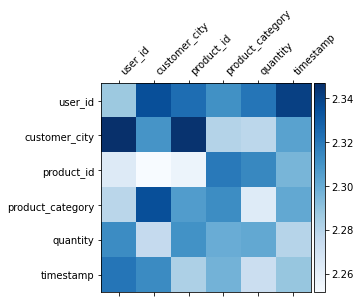

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

## access the kernel inside cross-network in the first later of the sequential layer in querymodel
mat = model.query_model.dense_layers.get_layer(index=0)._dense.kernel
features =  ['user_id', 
            'customer_city',
            'product_id', 
            'product_category',
            'quantity', 
            'timestamp']

block_norm = np.ones([len(features), len(features)])

dim = model.query_model.embedding_model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
    for j in range(len(features)):
        block = mat[i * dim:(i + 1) * dim,
                    j * dim:(j + 1) * dim]
        block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(9,9))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)